# TACO Inspection Demo

This notebook contains several independent scripts that show how to load and visualize the dataset stats and annotated images:
- Section 1 shows the dataset stats
- Section 2 show the class hierarchical structure: super classes and classes
- Section 3 shows TACO images along with their segmentation masks

But first we need to load the annotations and some python libraries:

In [1]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

dataset_path = '/dtu/datasets1/02514/data_wastedetection'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


In [2]:
id_im = 100

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
batch_11/000028.jpg
[0.0, 1139.0, 2394.0, 1963.0]
[618.0, 1224.0, 249.0, 242.0]
[984.0, 901.0, 440.0, 633.0]
[1014.0, 805.0, 447.0, 362.0]
[1196.0, 549.0, 262.0, 276.0]
[1479.0, 772.0, 596.0, 328.0]
[335.0, 641.0, 620.0, 511.0]


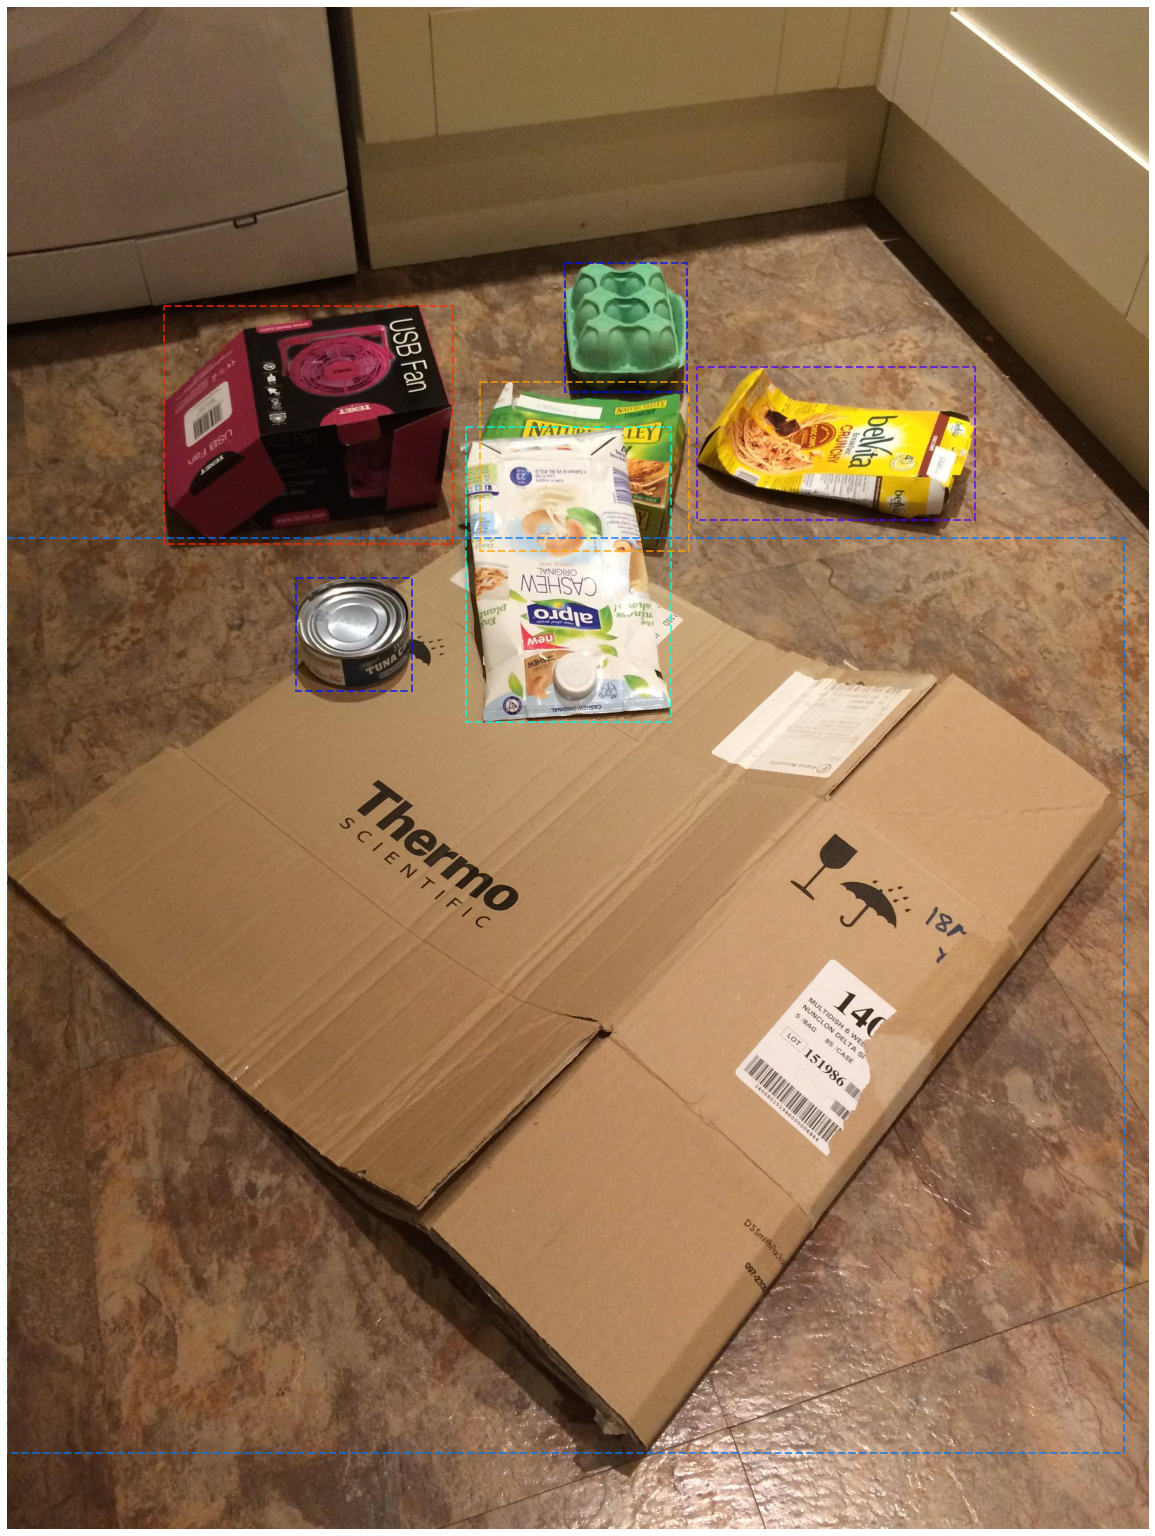

In [3]:
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

# User settings
image_filepath = 'batch_11/000028.jpg'
pylab.rcParams['figure.figsize'] = (28,28)
####################

# Obtain Exif orientation tag code
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break

# Loads dataset as a coco object
coco = COCO(anns_file_path)

# Find image id
img_id = -1
for img in imgs:
    if img['file_name'] == image_filepath:
        img_id = img['id']
        break

# Show image and corresponding annotations
if img_id == -1:
    print('Incorrect file name')
else:

    # Load image
    print(image_filepath)
    image_filepath = imgs[id_im]['file_name']
    I = Image.open(dataset_path + '/' + image_filepath)

    # Load and process image metadata
    if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180,expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270,expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90,expand=True)

    # Show image
    fig,ax = plt.subplots(1)
    plt.axis('off')
    plt.imshow(I)

    # Load mask ids
    annIds = coco.getAnnIds(imgIds=100, catIds=[], iscrowd=None)
    anns_sel = coco.loadAnns(annIds)

    # Show annotations
    for ann in anns_sel:
        color = colorsys.hsv_to_rgb(np.random.random(),1,1)
        [x, y, w, h] = ann['bbox']
        print(ann['bbox'])
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                         facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)

    plt.show()

In [58]:
basewidth = 600
wpercent = (basewidth/float(I.size[0]))
hsize = int((float(I.size[1])*float(wpercent)))
I = I.resize((basewidth,hsize), Image.ANTIALIAS)

/tmp/ipykernel_57747/1008233797.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  I = I.resize((basewidth,hsize), Image.ANTIALIAS)


[  0 186 391 320]
[100 200  40  39]
[160 147  71 103]
[165 131  73  59]
[195  89  42  45]
[241 126  97  53]
[ 54 104 101  83]


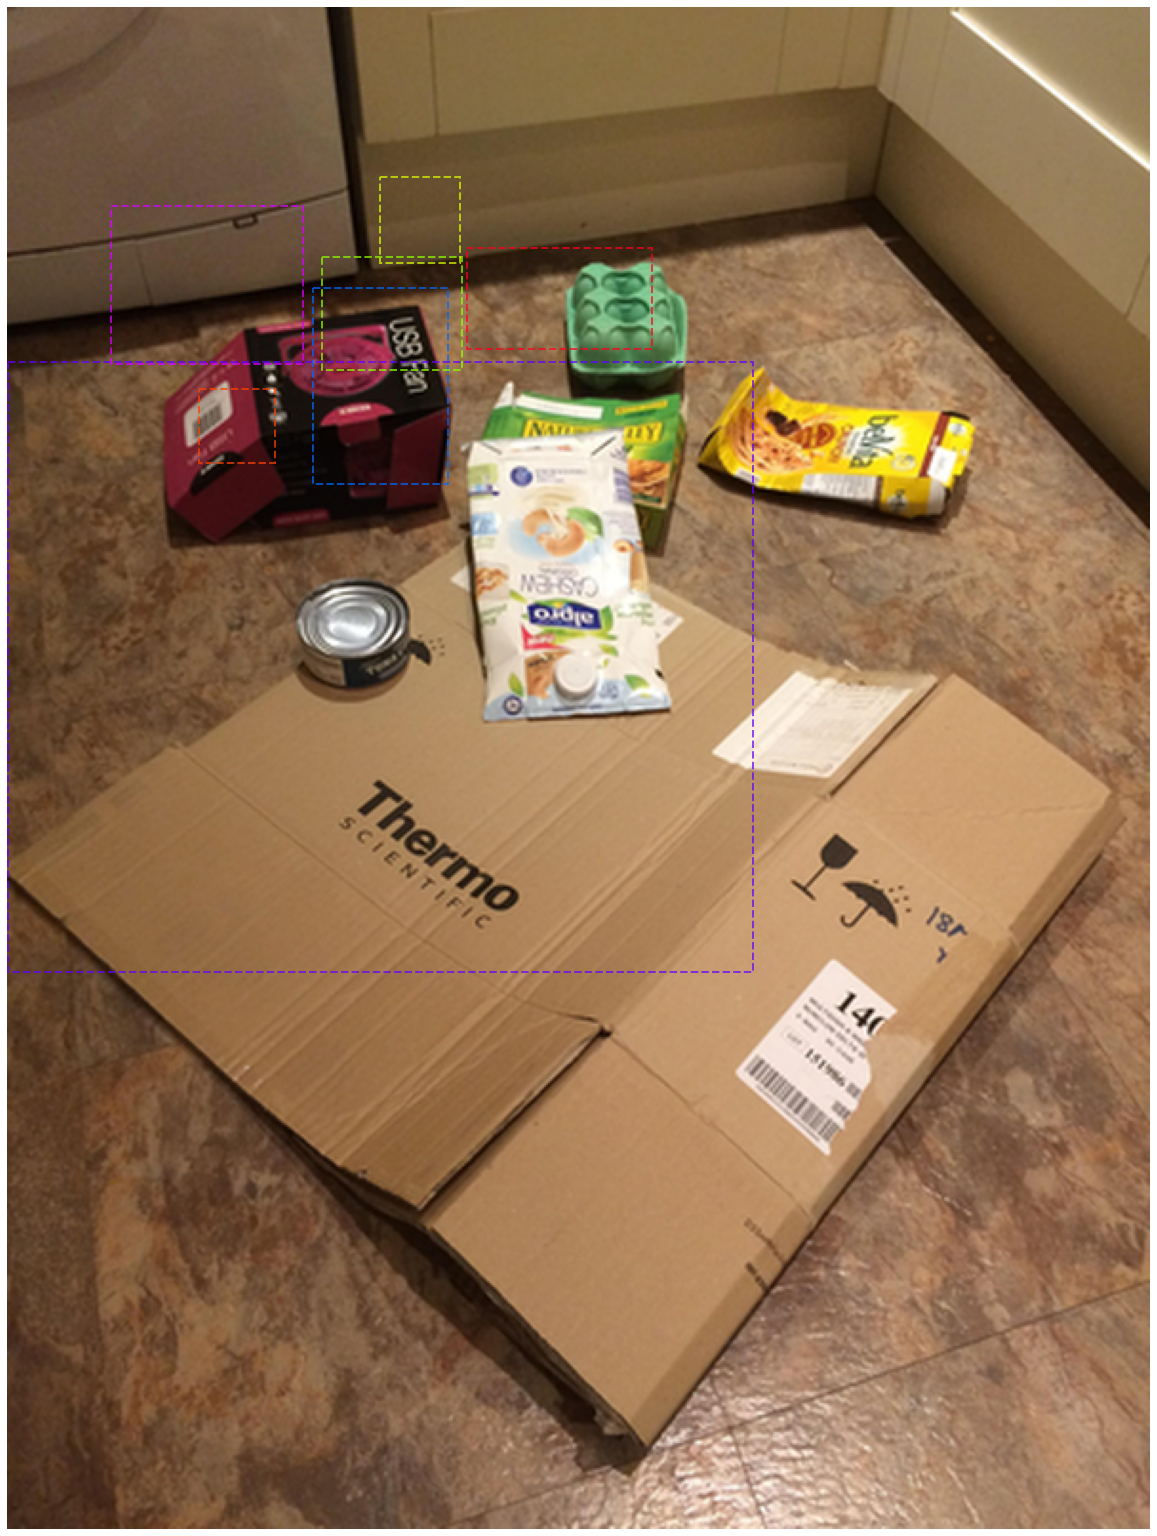

In [59]:
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(I)

# Load mask ids
annIds = coco.getAnnIds(imgIds=100, catIds=[], iscrowd=None)
anns_sel = coco.loadAnns(annIds)

# Show annotations
for bb in bbox_gt:
    color = colorsys.hsv_to_rgb(np.random.random(),1,1)
    [x, y, w, h] = bb
    print(bb)
    rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                     facecolor='none', alpha=0.7, linestyle = '--')
    ax.add_patch(rect)

plt.show()

In [6]:
#matplotlib inline
import glob
from math import floor
import os

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import PIL.Image as Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torch import utils

import random
from math import floor
import cv2

/zhome/10/4/164561/venv_3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [88]:
def selective_search(image):
    # return region proposals of selective searh over an image
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    return ss.process()

In [89]:
def calculate_IoU(bb1, bb2):
  # calculate IoU(Intersection over Union) of 2 boxes 
  # **IoU = Area of Overlap / Area of Union
  # https://github.com/Hulkido/RCNN/blob/master/RCNN.ipynb

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    # calculate Overlapping area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    union_area = bb1_area + bb2_area - intersection_area

    return intersection_area / union_area

In [90]:
def load_image_data(id_im, categories, anns, imgs, basewidth=1024, data_path='/dtu/datasets1/02514/data_wastedetection'):
    cat_names = []
    super_cat_names = []
    super_cat_ids = {}
    super_cat_last_name = ''
    nr_super_cats = 0
    for cat_it in categories:
        cat_names.append(cat_it['name'])
        super_cat_name = cat_it['supercategory']
        # Adding new supercat
        if super_cat_name != super_cat_last_name:
            super_cat_names.append(super_cat_name)
            super_cat_ids[super_cat_name] = nr_super_cats
            super_cat_last_name = super_cat_name
            nr_super_cats += 1
    
    image_filepath = imgs[id_im]['file_name']
    image = Image.open(data_path + '/' + image_filepath)
    bbox = []
    labels = []
    for d in anns:
        if d['image_id'] == id_im:
            cat = [cat for cat in categories if cat['id'] == d['category_id']][0]
            label = super_cat_ids[cat['supercategory']]
            labels.append(label)
            bbox.append(d['bbox'])
    bbox = torch.as_tensor(bbox)
    wpercent = (basewidth/float(image.size[0]))
    hsize = int((float(image.size[1])*float(wpercent)))
    image = image.resize((basewidth,hsize), Image.ANTIALIAS)
    bbox_gt = (bbox*wpercent).numpy().astype(int)
    
    return np.array(image), bbox_gt, labels

In [91]:
def weirdbbox2bbox(x,y,w,h):
    x1, y1 = x, y
    x2, y2 = x+w, y+h
    return {'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2}

In [92]:
def get_proposals(image, bbox_gt, labels, IoU_threshold=0.5, target_object_rate=0.3):
    obj_counter = 0
    bg_counter = 0
    train_images = []
    train_labels = []


    rects = selective_search(image)
    random.shuffle(rects)

    for (x, y, w, h) in rects:
        # apply padding
        best_iou = 0
        bbox_est = weirdbbox2bbox(x,y,w,h)
        for i, gt_bbox in enumerate(bbox_gt):
            [x,y,w,h]=gt_bbox
            gt_bbox = weirdbbox2bbox(x,y,w,h)
            iou = calculate_IoU(gt_bbox, bbox_est)

            if iou >= IoU_threshold: # if object(RoI > 0.5)
                if iou > best_iou:
                    best_iou = iou
                    best_i = i

        if best_iou > 0:
            obj_counter += 1
            cropped = image[bbox_est['y1']:bbox_est['y2'], bbox_est['x1']:bbox_est['x2'], :]
            train_images.append(cropped)
            train_labels.append([labels[best_i], bbox_gt[best_i], bbox_est])
            

        else:
            if (bg_counter+obj_counter) > 0:
                if obj_counter/(bg_counter+obj_counter) >= target_object_rate:
                    bg_counter+=1
                    cropped = image[bbox_est['y1']:bbox_est['y2'], bbox_est['x1']:bbox_est['x2'], :]
                    train_images.append(cropped)
                    train_labels.append([28, np.array([1,1,1,1]), bbox_est])

    return train_images, train_labels


In [93]:
class WasteInWild(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform):
        'Initialization'
        self.transform = transform
        self.images = images
        self.labels = labels

    def __len__(self):
        'Returns the total number of samples'
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        X = self.transform(image)
        y = self.labels[idx][0]
        bbox_gt = self.labels[idx][1]
        bbox_ext = self.labels[idx][2]
        return  X, y, bbox_gt, bbox_ext  

def get_data(train_images, train_labels, batch_size=16):
    size = 224 


    train_transform = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((size, size)), 
                                        transforms.ToTensor(), 
                                        ])
    test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                        transforms.ToTensor()
                                        ])

    trainset = WasteInWild(train_images, train_labels, transform=train_transform)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)

    return train_loader

In [94]:
fullIdList = list(range(1500))
random.shuffle(fullIdList)

train = fullIdList[0:floor(1500*0.6)]

val = fullIdList[floor(1500*0.6):(floor(1500*0.6)+floor(1500*0.2))]

test = fullIdList[floor(1500*0.8):(floor(1500*0.8)+floor(1500*0.2))]

In [95]:
data_path='/dtu/datasets1/02514/data_wastedetection'
anns_file_path = data_path + '/' + 'annotations.json'
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
    
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']    

In [96]:
id_im = 100
IoU_threshold=0.5
target_object_rate=0.3

In [97]:
im, bbox_gt, labels = load_image_data(id_im=id_im, categories=categories, anns=anns, imgs=imgs)

/tmp/ipykernel_57747/204178340.py:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((basewidth,hsize), Image.ANTIALIAS)


In [98]:
train_images, train_labels = get_proposals(im, bbox_gt, labels, IoU_threshold=0.5)

In [99]:
train_loader = get_data(train_images, train_labels)

In [101]:
batch = next(iter(train_loader))

tensor([[[[0.7882, 0.7843, 0.7804,  ..., 0.8157, 0.8157, 0.8157],
          [0.7922, 0.7882, 0.7843,  ..., 0.8196, 0.8118, 0.8118],
          [0.7922, 0.7922, 0.7922,  ..., 0.8118, 0.8078, 0.8078],
          ...,
          [0.7451, 0.7451, 0.7451,  ..., 0.4824, 0.4902, 0.4980],
          [0.7451, 0.7451, 0.7490,  ..., 0.4824, 0.4941, 0.5059],
          [0.7451, 0.7451, 0.7451,  ..., 0.4745, 0.4784, 0.4824]],

         [[0.6118, 0.6078, 0.6039,  ..., 0.6392, 0.6392, 0.6392],
          [0.6157, 0.6118, 0.6078,  ..., 0.6431, 0.6353, 0.6353],
          [0.6157, 0.6157, 0.6157,  ..., 0.6353, 0.6314, 0.6314],
          ...,
          [0.5608, 0.5608, 0.5608,  ..., 0.3569, 0.3608, 0.3647],
          [0.5608, 0.5608, 0.5647,  ..., 0.3569, 0.3647, 0.3686],
          [0.5608, 0.5608, 0.5608,  ..., 0.3529, 0.3490, 0.3490]],

         [[0.4510, 0.4471, 0.4431,  ..., 0.4745, 0.4745, 0.4745],
          [0.4549, 0.4510, 0.4471,  ..., 0.4784, 0.4706, 0.4706],
          [0.4549, 0.4549, 0.4549,  ..., 0

In [104]:
im_ex = batch[0][0]

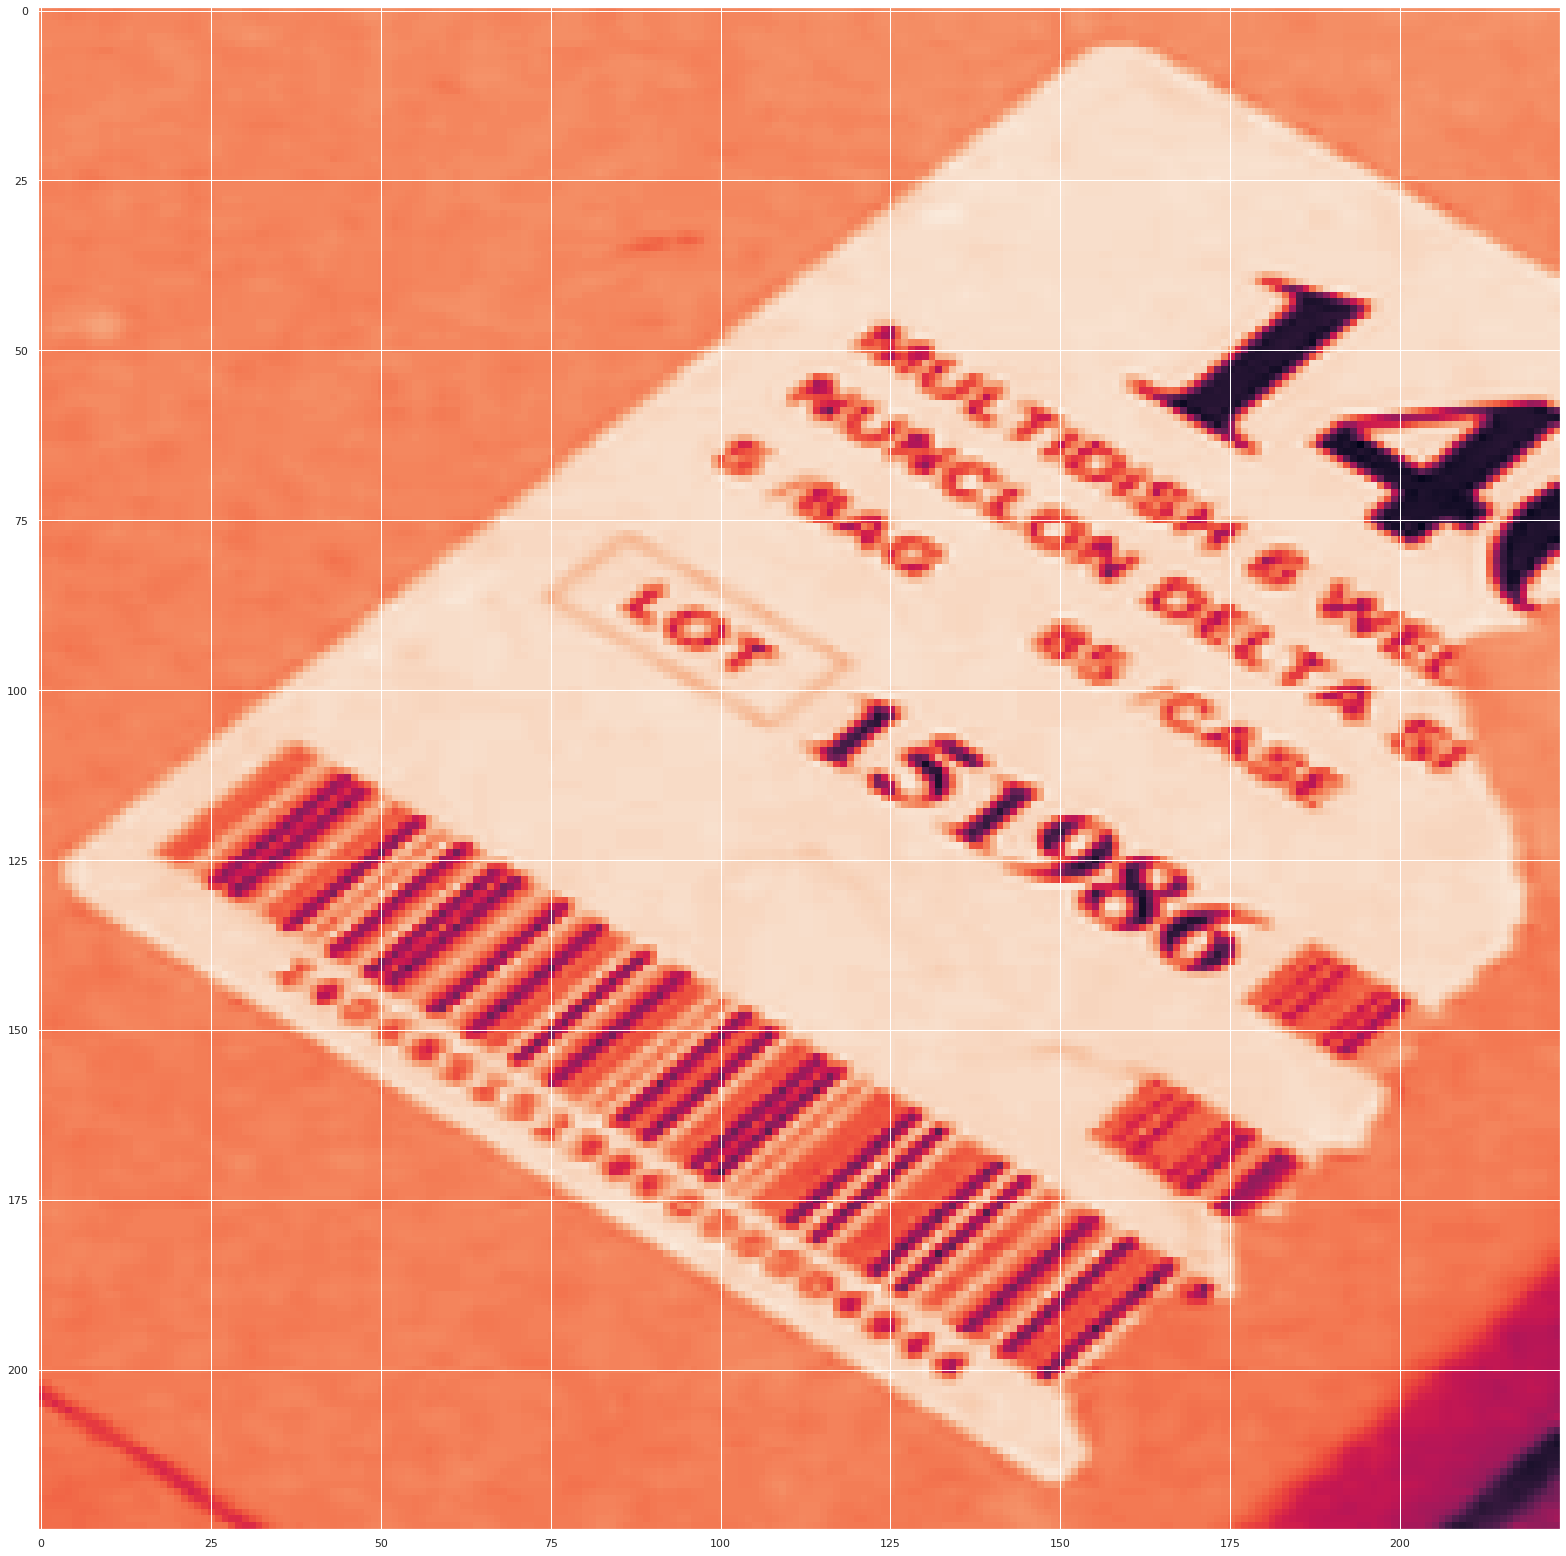

In [105]:
plt.imshow(batch[0][0][0,:,:])

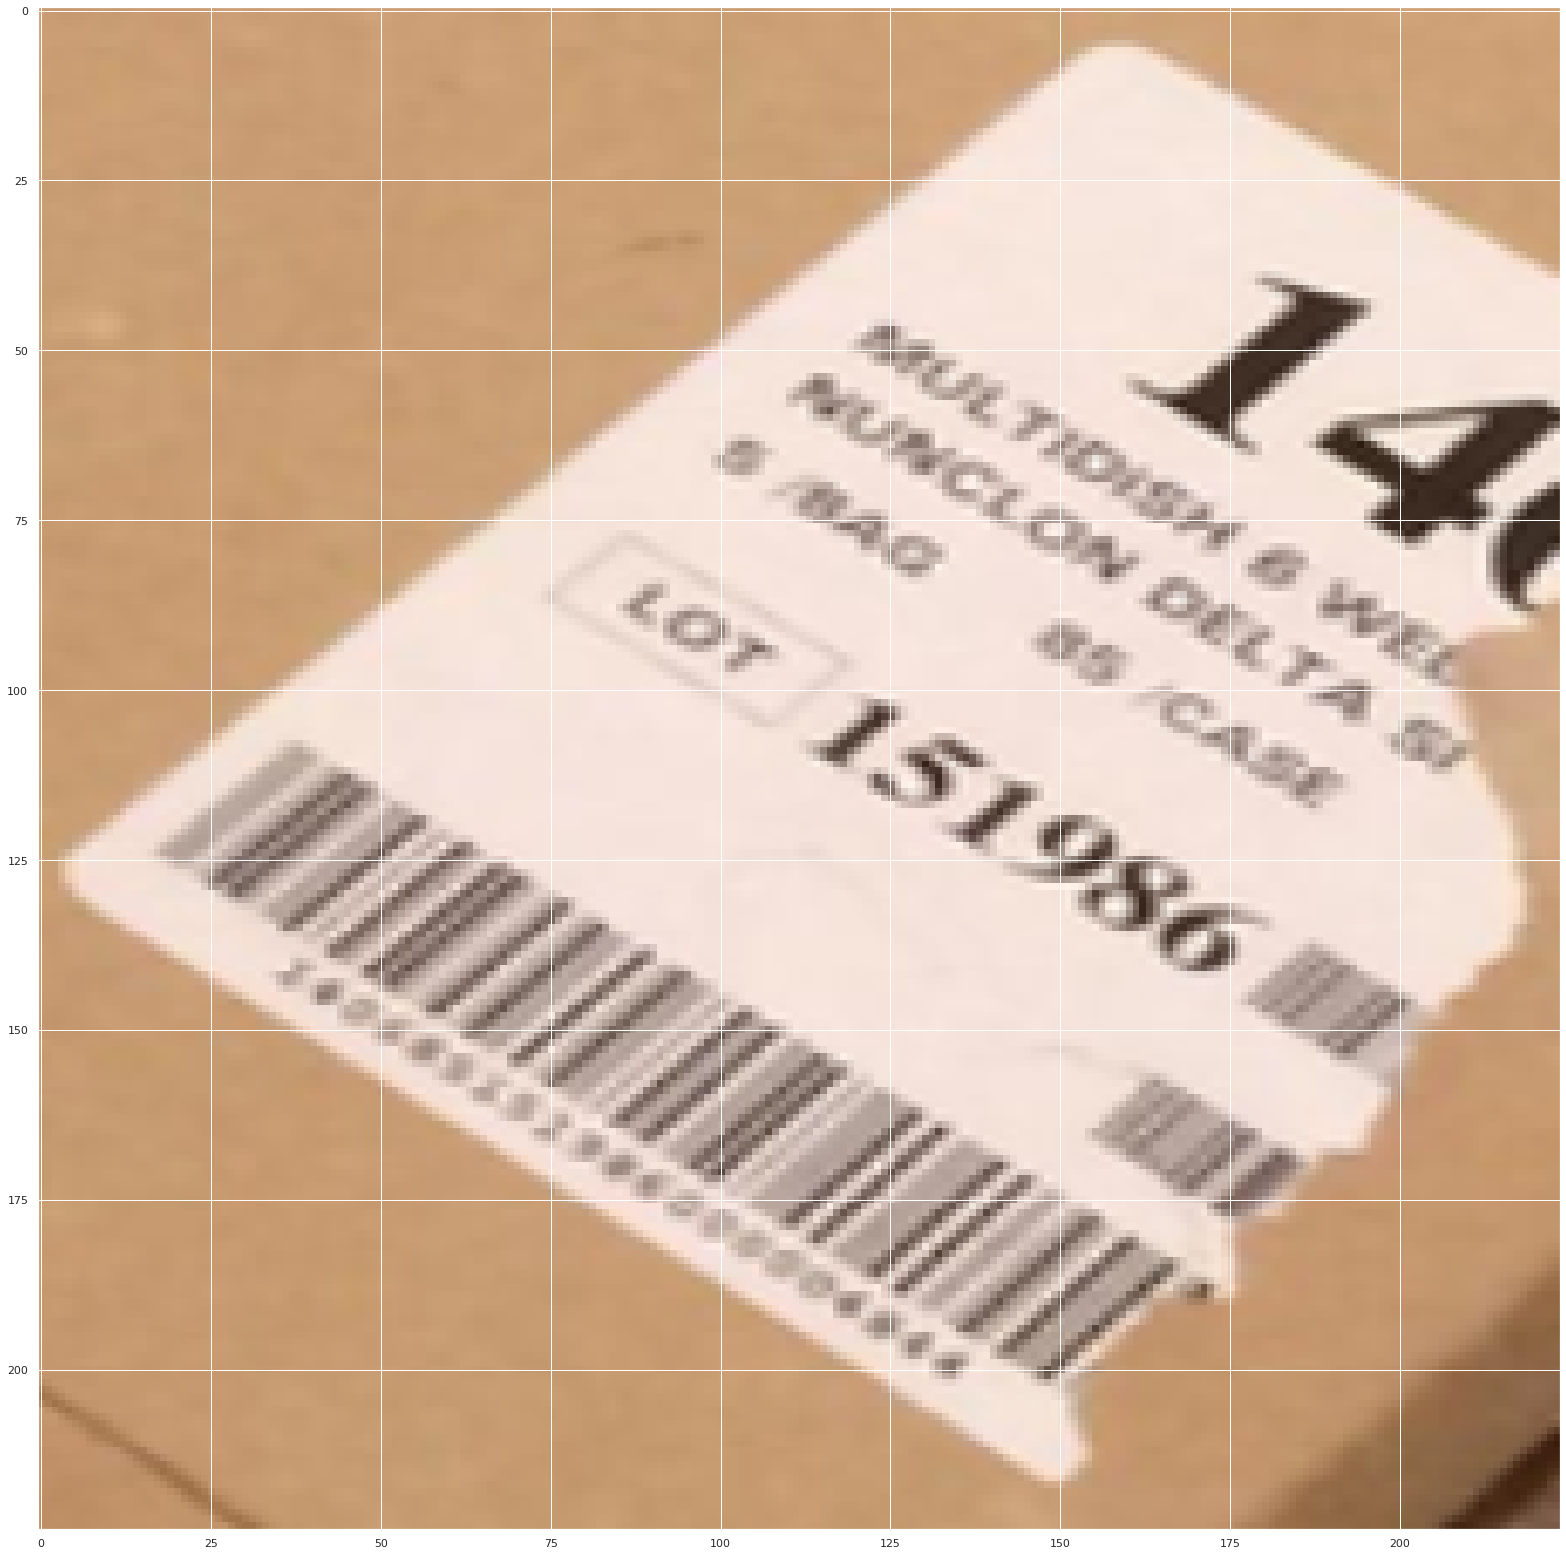

In [106]:
plt.imshow(im_ex.permute(1,2,0))

In [107]:
def get_device():
    if torch.cuda.is_available():
        print("The code will run on GPU.")
    else:
        print("The code will run on CPU")
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [108]:
import torchvision.models as models

In [146]:
class FinetuneResnet50(nn.Module):
    def __init__(self, num_classes, pretrained = True):
        super(FinetuneResnet50, self).__init__()

        self.model = models.resnet50(pretrained=pretrained)
        self.fc1 = nn.Linear(2048, 2048)
        self.fc2 = nn.Linear(2048, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)

        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [110]:
class FinetuneResnet50test(nn.Module):
    def __init__(self, num_classes, pretrained = True):
        super(FinetuneResnet50test, self).__init__()

        self.model = models.resnet50(pretrained=pretrained)
        self.fc1 = nn.Linear(2048, 2048)
        self.fc2 = nn.Linear(2048, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        print(f'init: {x.shape}')
        x = self.model.conv1(x)
        print(x.shape)
        x = self.model.bn1(x)
        print(x.shape)
        x = self.model.relu(x)
        print(x.shape)
        x = self.model.maxpool(x)
        print(x.shape)
        x = self.model.layer1(x)
        print(x.shape)
        x = self.model.layer2(x)
        print(x.shape)
        x = self.model.layer3(x)
        print(x.shape)
        x = self.model.layer4(x)
        print(x.shape)
        x = self.model.avgpool(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = nn.functional.relu(self.fc1(x))
        print(x.shape)
        x = self.dropout(x)
        print(x.shape)
        x = self.fc2(x)
        print('out')

        return x

In [111]:
import numpy as np
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader



def train(model, optimizer, train_ids, test_ids, device, num_epochs=50, patience = 10):
    def loss_fun(output, target):
        return F.cross_entropy(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    for epoch in range(num_epochs):
        print(epoch)
        for id_im in train_ids:
            try:
                im, bbox_gt, labels = load_image_data(id_im=id_im, categories=categories, anns=anns, imgs=imgs)
                train_images, train_labels = get_proposals(im, bbox_gt, labels, IoU_threshold=0.5)
                train_loader = get_data(train_images, train_labels)
                model.train()
                #For each epoch
                train_correct = 0
                train_loss = []
                for minibatch_no, (data, target) in enumerate(train_loader):
                    data, target = data.to(device), target.to(device)
                    #Zero the gradients computed for each weight
                    optimizer.zero_grad()
                    #Forward pass your image through the network
                    output = model(data)
                    #Compute the loss
                    loss = loss_fun(output, target)
                    #Backward pass through the network
                    loss.backward()
                    #Update the weights
                    optimizer.step()

                    train_loss.append(loss.item())
                    #Compute how many were correctly classified
                    predicted = F.softmax(output, dim=1).argmax(1)
                    train_correct += (target==predicted).sum().cpu().item()
        #         #Comput the test accuracy
        #         test_loss = []
        #         test_correct = 0
        #         model.eval()
        #         for data, target in test_loader:
        #             data, target = data.to(device), target.to(device)
        #             with torch.no_grad():
        #                 output = model(data)
        #             test_loss.append(loss_fun(output, target).cpu().item())
        #             predicted =  F.softmax(output, dim=1).argmax(1)
        #             test_correct += (target==predicted).sum().cpu().item()
                out_dict['train_acc'].append(train_correct/len(train_loader.dataset))
        #         out_dict['test_acc'].append(test_correct/len(test_loader.dataset))
                out_dict['train_loss'].append(np.mean(train_loss))
        #         out_dict['test_loss'].append(np.mean(test_loss))
        #         print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
        #               f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%\t",
        #               f"Memory allocated: {torch.cuda.memory_allocated(device=device)/1e9:.1f} GB")
                print(f"Loss train: {np.mean(train_loss):.3f}\t",f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%")
            # Early stopping 
    #         if epoch > 10 and out_dict['test_acc'][-1] < out_dict['test_acc'][-2]:
    #             patience -= 1
    #             if patience == 0:
    #                 print("Early stopping")
    #                 break
            except: 
                print('Fail')
                return data

    return out_dict

In [147]:
device = get_device()

# model = FinetuneResnet50(29)
model = FinetuneResnet50(29)
# model = ResNet(3,16, num_res_blocks=8)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


training_stats = train(model, optimizer, train_ids, train_ids, device, 5)

The code will run on GPU.
0


/tmp/ipykernel_57747/204178340.py:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((basewidth,hsize), Image.ANTIALIAS)


Loss train: 2.608	 Accuracy train: 32.4%
Loss train: 1.001	 Accuracy train: 65.8%
Loss train: 1.686	 Accuracy train: 51.6%
Loss train: 1.325	 Accuracy train: 50.7%
Loss train: 1.198	 Accuracy train: 71.4%
Loss train: 2.079	 Accuracy train: 70.0%
Loss train: 2.866	 Accuracy train: 71.0%
Loss train: 1.393	 Accuracy train: 70.8%
Loss train: 2.523	 Accuracy train: 67.6%
Loss train: 1.385	 Accuracy train: 66.0%
1
Loss train: 0.630	 Accuracy train: 70.4%
Loss train: 1.172	 Accuracy train: 70.2%
Loss train: 2.834	 Accuracy train: 70.1%
Loss train: 0.786	 Accuracy train: 70.2%
Loss train: 0.954	 Accuracy train: 75.0%
Loss train: 0.904	 Accuracy train: 70.1%
Loss train: 0.542	 Accuracy train: 96.8%
Loss train: 1.062	 Accuracy train: 62.5%
Loss train: 1.271	 Accuracy train: 61.0%
Loss train: 1.082	 Accuracy train: 71.6%
2
Loss train: 0.835	 Accuracy train: 70.2%
Loss train: 1.174	 Accuracy train: 70.3%
Loss train: 1.447	 Accuracy train: 68.8%
Loss train: 0.891	 Accuracy train: 66.7%
Loss train: 

# Test 

In [128]:
import torchvision

In [143]:
class testDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform):
        'Initialization'
        self.transform = transform
        self.images = images

    def __len__(self):
        'Returns the total number of samples'
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        X = self.transform(image)
        return  X

In [168]:
def test(images_ids, model):
    outputs = {}
    device = get_device()
    model.to(device)
    for img_id in images_ids:
        outputs[img_id] = {}
        classes, scores = np.array([]), np.array([])
        img, bbox_gt, labels = load_image_data(id_im=img_id, categories=categories, anns=anns, imgs=imgs)
        rects = selective_search(img)
        img = transforms.ToPILImage()(img)
        proposal_imgs = []
        for (x, y, w, h) in rects:
            bbox_est = weirdbbox2bbox(x,y,w,h)
            cropped_img = torchvision.transforms.functional.crop(img, bbox_est['x1'], bbox_est['y1'], bbox_est['x2'], bbox_est['y2'])
            proposal_imgs.append(cropped_img)
            
        test_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.ToTensor()
                                        ])
        dataset = testDataset(images=proposal_imgs, transform=test_transform)
        dataloader = DataLoader(dataset, batch_size=16)
        for i, input_img in enumerate(dataloader):
            print(input_img.shape)
            print(device)
            input_img.to('cuda')
            print(input_img.is_cuda)
            output = model(input_img)
            score, pred_class = torch.max(output, 1)
            classes = np.append(classes, pred_class.detach().numpy())
            scores = np.append(scores, score.detach().numpy())
        outputs['classes'] = classes
        outputs['scores'] = scores
    return outputs

In [170]:
outputs = {}
device = get_device()
model.to(device)
for img_id in [100]:
    outputs[img_id] = {}
    classes, scores = np.array([]), np.array([])
    img, bbox_gt, labels = load_image_data(id_im=img_id, categories=categories, anns=anns, imgs=imgs)
    rects = selective_search(img)
    img = transforms.ToPILImage()(img)
    proposal_imgs = []
    for (x, y, w, h) in rects:
        bbox_est = weirdbbox2bbox(x,y,w,h)
        cropped_img = torchvision.transforms.functional.crop(img, bbox_est['x1'], bbox_est['y1'], bbox_est['x2'], bbox_est['y2'])
        proposal_imgs.append(cropped_img)

    test_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                    transforms.ToTensor()
                                    ])
    dataset = testDataset(images=proposal_imgs, transform=test_transform)
    dataloader = DataLoader(dataset, batch_size=16)
    for i, input_img in enumerate(dataloader):
        print(input_img.shape)
        print(device)
        input_img.to('cuda')
        print(input_img.is_cuda)
        output = model(input_img)
        score, pred_class = torch.max(output, 1)
        classes = np.append(classes, pred_class.detach().numpy())
        scores = np.append(scores, score.detach().numpy())
    outputs['classes'] = classes
    outputs['scores'] = scores

The code will run on GPU.


/tmp/ipykernel_57747/204178340.py:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((basewidth,hsize), Image.ANTIALIAS)


torch.Size([16, 3, 224, 224])
cuda
False


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [172]:
dataloader

In [171]:
batch = next(iter(train_loader))

TypeError: 'DataLoader' object is not an iterator

In [169]:
outputs = test([20,100], model)

The code will run on GPU.


/tmp/ipykernel_57747/204178340.py:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((basewidth,hsize), Image.ANTIALIAS)


torch.Size([16, 3, 224, 224])
cuda
False


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [155]:
model.state_dict

<bound method Module.state_dict of FinetuneResnet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
  